## Introduction

This tutorial will introduce you to some methods of AB experiment analysis in actual work, how to conduct hypothesis testing for some common statistics, and what methods should be used when it does not conform to the normal distribution. How can we deal with the low penetration rate problem in the AB experiment ( How to get a significant effect when the experiment actually takes effect in a small number of people).

### Tutorial content

In this tutorial, we will show how to analyze some AB experiments in Python, especially using scipy.stats, sklearn.

In this tutorial, we will use some data sets actually used in my previous work (data has been processed into masked data) to share with you the analysis code related to the AB experiment. As there are many types of data sets, I will give specific explanations on the data sets when sharing specific cases.

We will cover the following topics in this tutorial:
- [Installing the libraries](#Installing-the-libraries)
- [Hypothesis testing](#Hypothesis-testing)
- [Calculation of Confidence Interval of Actual Case](#Calculation-of-Confidence-Interval-of-Actual-Case)
- [How to use bootstrap](#[How-to-use-bootstrap)
- [How to do matching(PSM) in AB test](#How-to-do-matching-in-AB-test)

## Installing the libraries

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import numpy as np
import statsmodels.stats.proportion as sp
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1) Hypothesis testing
### 1.1 Compare the significance of two continuous variables
- Example: App Usage Time, Watching Live/Videos Time
- T-test

In [ ]:
from scipy import stats
from scipy.stats import chi2_contingency
import scipy.stats as ss
from scipy.stats import chi2

In [ ]:
data = pd.read_csv('live_duration.csv')

- This is an AB experiment about the length of time users spend on the app. The first column is the date, the second column is the different platform, and the third column is the experimental group and the control group. In order to simplify the analysis, we will combine platforms A and B here. In addition, we can see that we have two experimental groups and two control groups. In actual work, we usually set two and use the average of the two experimental groups/control groups to replace the data performance of the real experimental group/control group. This is to eliminate some differences between groups.

In [ ]:
data.head()

,date,platform,group,play_duration
0,20201205,platformB,exp2,42200000.0
1,20201204,platformB,exp2,41400000.0
2,20201202,platformB,exp2,40900000.0
3,20201201,platformB,exp2,40300000.0
4,20201203,platformB,exp2,41300000.0


In [ ]:
# '|' means or
duration_base_list = data[(data['group'] == 'base1') | (data['group'] == 'base2')]['play_duration'].tolist()
duration_exp_list = data[(data['group'] == 'exp1') | (data['group'] == 'exp2')]['play_duration'].tolist()

In [ ]:
# Calculate the T-test for the means of two independent samples of scores.
# scipy.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='two-sided')

print(stats.ttest_ind(duration_base_list, duration_exp_list))
print('Conclusion: Because the p-value=0.995>0.05, we couldn`t reject the null hypothesis \n it is considered that there is no significant difference in the play_duration between the two groups.')

Ttest_indResult(statistic=0.006066720328514306, pvalue=0.9951912252889245)
Conclusion: Because the p-value=0.995>0.05, we couldn`t reject the null hypothesis 
 it is considered that there is no significant difference in the play_duration between the two groups.


Perform Levene test for equal variances.
When you are not sure whether the variances of the two populations are equal, 
you should first use the levene test to test whether the two populations have the same variance. If the p-value of the returned result is much greater than 0.05, then we believe that the two populations have homogeneity of variance. If the two populations do not have homogeneity of variance, the parameter equal_val needs to be added and set to False.


In [ ]:
stats.levene(duration_base_list,duration_exp_list)

LeveneResult(statistic=0.07728731687164331, pvalue=0.7825148652227745)

In [ ]:
stats.ttest_ind(duration_base_list,duration_exp_list,equal_var=False)

Ttest_indResult(statistic=0.006066720328514306, pvalue=0.9951912254105626)

In [ ]:
# Get difference between two groups
gap = np.array(duration_exp_list) - np.array(duration_base_list)
# Calculate the confidence interval, degrees of freedom 19
t = 2.093
# Calculate standard error
se = ss.sem(gap)
# Upper limit of confidence interval
a = gap.mean() - t * se
# Lower limit of confidence interval
b = gap.mean() + t * se
print('Confidence interval of the difference between a single mean, 95 confidence level CI=(%f,%f)' % (a,b))

Confidence interval of the difference between a single mean, 95 confidence level CI=(-615251.758148,455251.758148)


### 1.2 Compare the significance of two sets of binary variables
- Example: Retention、gender
- Chi-square test

Here will build a simple example for demonstration. We set the two elements in group 1 and group 2 to represent the number of women and men respectively. For this kind of binary variable, when we count the numbers corresponding to each variable, we can perform a chi-square test.

In [ ]:
group1 = [12, 27] # 12 females and 27 males
group2 = [39, 21] # 39 females and 21 males

kf_data = np.array([group1, group2])

In [ ]:
# scipy.stats.chi2_contingency(observed, correction=True, lambda_=None)
# Chi-square test of independence of variables in a contingency table.

kf = chi2_contingency(kf_data)
print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%kf)
print('Conclusion: Because p-value = 0.0018 <0.05, the null hypothesis is rejected, \nand there is a significant difference between men and women in the two groups.')

chisq-statistic=9.7604, p-value=0.0018, df=1 expected_frep=[[20.09090909 18.90909091]
 [30.90909091 29.09090909]]
Conclusion: Because p-value = 0.0018 <0.05, the null hypothesis is rejected, 
and there is a significant difference between men and women in the two groups.


In [ ]:
# We can get from chi2_contingency including: stat chi-square statistic value, p: P_value, 
# dof degrees of freedom, expected theoretical frequency distribution
stat,p,dof,expected = chi2_contingency(kf_data)

In [ ]:
prob = 0.95 # Set 95% confidence level
critical = chi2.ppf(prob,dof)  # Calculate critical threshold
print('probality=%.3f,critical=%.3f,stat=%.3f '%(prob,critical,stat))
if abs(stat) >= critical:
    print('reject H0:Dependent')
else:
    print('fail to reject H0:Independent')

probality=0.950,critical=3.841,stat=9.760 
reject H0:Dependent


## 2 Calculation of Confidence Interval of Actual Case
### 2.1 Daily Active User（DAU） confidence interval

$$(\overline{x}_{exp}-\overline{x}_{base}) \pm Z_{\alpha/2} \sqrt{\frac{s_{exp}^2}{n_{exp}}+\frac{s_{base}^2}{n_{base}}}$$

In [ ]:
import math

This is an AB experiment on the impact of advertisements on the APP on the user's DAU and retention rate. The first column is the date, the second column is the experimental group and the control group, the third column is DAU, the fourth column is the number of people retained for the next day, and the fifth column is the retention rate.

In [ ]:
dau_data = pd.read_csv('dau_data.csv')

In [ ]:
dau_data.head()

,date,group,user_num,retention_num,retention_rate
0,2020/12/4,exp1,5023479,4153644,0.826846
1,2020/12/3,exp1,4822401,3959466,0.821057
2,2020/12/2,exp1,4828498,4142844,0.857998
3,2020/12/1,exp1,5219291,4144141,0.794005
4,2020/11/30,exp1,5239801,4129792,0.788158


In [ ]:
# Split the dataset based on groups
df_dau_base = dau_data.loc[((dau_data["group"].isin(["base1"])))].drop(['group'], axis=1)
df_dau_exp = dau_data.loc[((dau_data["group"].isin(["exp1"])))].drop(['group'], axis=1)

In [ ]:
# data_processing 
base_mean = df_dau_base['user_num'].mean()
base_std = df_dau_base['user_num'].std()
base_n = df_dau_base['user_num'].count()
exp_mean = df_dau_exp['user_num'].mean()
exp_std = df_dau_exp['user_num'].std()
exp_n = df_dau_exp['user_num'].count()

In [ ]:
interval_left = (exp_mean - base_mean) - 1.96*(math.sqrt((pow(exp_std,2)/exp_n)+(pow(base_std,2)/base_n)))
interval_right = (exp_mean - base_mean) + 1.96*(math.sqrt((pow(exp_std,2)/exp_n)+(pow(base_std,2)/base_n)))
print('The confidence interval is', '[', interval_left, ']', '[' ,interval_right, ']')
print('Since the confidence interval includes 0, \nthe null hypothesis cannot be rejected, and there is no significant difference between exp and base')

The confidence interval is [ -233768.11880306294 ] [ 153198.11880306294 ]
Since the confidence interval includes 0, 
the null hypothesis cannot be rejected, and there is no significant difference between exp and base


### 2.2 Retention rate return (calculation method of confidence interval for sub-retention rate)

$$(\Delta{1}) \pm Z_{\alpha/2} \sqrt{\frac{r_{1}{,}{exp}\ast(1-r_{1}{,}{exp})}{n_{exp}}+\frac{r_{1}{,}{base}\ast(1-r_{1}{,}{base})}{n_{base}}}$$

#### Retention rate confidence interval:
User retention, that is, whether the second day (or the seventh day) is active is a 0-1 distribution (0 inactive/1 active). According to the central limit theorem, when n is large enough, the normal distribution can be used to approximate 0 -1 mean of the distribution,

That is to say, the retention rates of the exp and base groups all obey the normal distribution, so the hypothesis test of the two normal populations can be used to judge whether there is a significant difference between the exp group and the base group.

In [ ]:
# data_processing 
base_mean = df_dau_base['retention_rate'].mean()
base_std = df_dau_base['retention_rate'].std()
base_n = df_dau_base['retention_rate'].count()
exp_mean = df_dau_exp['retention_rate'].mean()
exp_std = df_dau_exp['retention_rate'].std()
exp_n = df_dau_exp['retention_rate'].count()

In [ ]:
interval_left = (exp_mean - base_mean) - 1.96*(math.sqrt((pow(exp_std,2)/exp_n)+(pow(base_std,2)/base_n)))
interval_right = (exp_mean - base_mean) + 1.96*(math.sqrt((pow(exp_std,2)/exp_n)+(pow(base_std,2)/base_n)))
print('The confidence interval is', '[', interval_left, ']', '[' ,interval_right, ']')
print('From the confidence interval, we can see that the experimental group has a certain negative impact \non the retention rate relative to the control group.')

The confidence interval is [ -0.05332314389634143 ] [ -0.0033645869036587964 ]
From the confidence interval, we can see that the experimental group has a certain negative impact 
on the retention rate relative to the control group.


### 2.3 Confidence interval of other indicators - bootstrap

What is bootstrap?

- The definition of Bootstrap is to use a limited sample through repeated sampling to establish a sufficient sample, which solves the problem of insufficient sample in machine learning. In fact, it is what we usually call bagging.

- Bootstrap is a non-parametric statistical method, its essence is to resample the observation information, and then make statistical inferences on the distribution characteristics of the population.

Why do Bootstrap sampling

- Compared with the commonly used t-test and z-test, Bootstrap confidence interval calculation does not rely on the assumption of sample distribution, and has a weaker dependence on data, and can be applied to data of various distributions.
- It is a good choice when the data set is small. The samples obtained by random sampling multiple times are used as the training set, and the initial data is used as the test set.
- It is helpful for integrated learning methods.
-The disadvantage is that it may lead to estimation bias. The data set generated by Bootstrap changes the distribution of the initial data set.

Bootstrap specific steps

1. Use resampling techniques to draw a certain number of samples from the original sample.
2. Calculate the given statistic T based on the selected sample.
3. Repeat the above n times (generally greater than 1000) to obtain n statistics T.
4. Calculate the sample variance of the above n statistics T, and get the variance of the statistics.
In the same way, the new sample set can be used to estimate the population mean and other statistics.

In [ ]:
import seaborn as sns

In [ ]:
ad_change_df = pd.read_csv('ad_type_change.csv')

In this case, we want to explore the difference between the video play duration (photo_play_duration) in the experimental group exp1 and the control group base1. To calculate the confidence interval for the difference between the two groups, since the playback time does not conform to the normal distribution, we need to use bootstrap to calculate the mean difference between the two to construct a normal distribution and calculate the confidence interval.

In [ ]:
ad_change_df.head()

,user_id,group_name,online_duration,photo_play_duration,live_play_duration
0,624996,exp1,5.041700,0.000000,0.000000
1,494520,exp1,45.178367,44.624167,0.189750
2,982620,exp1,318.594650,356.518883,3.008683
3,523422,exp1,206.828100,86.854817,152.849800
4,948905,exp1,54.520367,17.248850,32.742133


In [ ]:
df_base = ad_change_df.loc[((ad_change_df["group_name"].isin(["base1"])))]
df_exp = ad_change_df.loc[((ad_change_df["group_name"].isin(["exp1"])))]

We can see that the current distribution does not conform to the normal distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


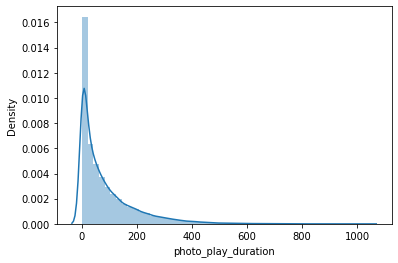

In [ ]:
# View data set distribution
sns.distplot(df_base['photo_play_duration'])

In [ ]:
df_base_col = df_base['photo_play_duration']
df_exp_col = df_exp['photo_play_duration']

In [ ]:
# Random replacement to draw gap
photo_diff_list =[] 
photo_diff = 0.0

for i in range(3000): # Do 3000 times experiment
    boot_diff_random_base = df_base_col.sample(len(df_base_col),replace=True) # Reorder all and put back
    boot_diff_random_exp = df_exp_col.sample(len(df_exp_col),replace=True)
    photo_diff = boot_diff_random_base.mean() - boot_diff_random_exp.mean() # Calculate the mean difference once and add it to boot_mean_diff
    photo_diff_list.append(photo_diff)

In [141]:
print("difference of Video Watching confidence interval：", np.percentile(photo_diff_list,[2.5,97.5]))

difference of Video Watching confidence interval： [-0.674618    1.94699479]


Now let’s take a look, the distribution of the mean difference has become a normal distribution. So we can get the confidence interval directly by taking the quantile.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


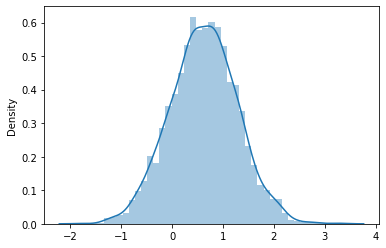

In [ ]:
sns.distplot(photo_diff_list)

## 3) Matching (PSM)

- What is matching and why use matching？

Low penetration rate: In some AB experiments, the actual experiment effective population only accounts for a small part of the whole. We will find that there is no significant impact in the overall comparison. We need to find similar users based on the user's characteristic behaviors, so as to analyze the effects of similar users after receiving the policy influence, and then evaluate the strategy or function. 

- Propensity Score Matching（PSM）

  1. As a matching method, the biggest purpose of PSM is to control the observed variables of the experimental group and the control group, especially when a random sample cannot get a significant effect. For example, we want to compare the health status of smokers and non-smokers. We selected two groups of people as samples. The following two situations may occur: 1. The smokers we selected are younger and healthier. The non-smokers are older or weaker. Finally, after observing for a period of time, we concluded that smoking is harmless. 2. People who smoke also like to drink, and people who smoke do not pay attention to their own health and so on. Affected by these factors, we have come to the conclusion that smoking is harmful to health. Both of these conclusions are unscientific. Such problems can be solved by matching.

  2. The matching method of PSM uses group variables as dependent variables and other characteristic variables as independent variables. Taking the example of smoking, then the dependent variable y is whether to smoke or not, and the independent variable is a series of other observable variables, such as whether to drink alcohol, age, gender, historical health status before smoking, etc. Then the regression results are further fitted to the probability of smoking, and a propensity score is obtained. After calculating the propensity scores of all individuals in the two sets of samples, we are matching the probabilities to find the two closest probabilities between the two groups. For individuals, we use a caliper to control the closest probability difference. Once the min(delta(score))>caliper of two individuals, then the two individuals will not match.

  - The handwritten figure below is a simple example of PSM method matching.




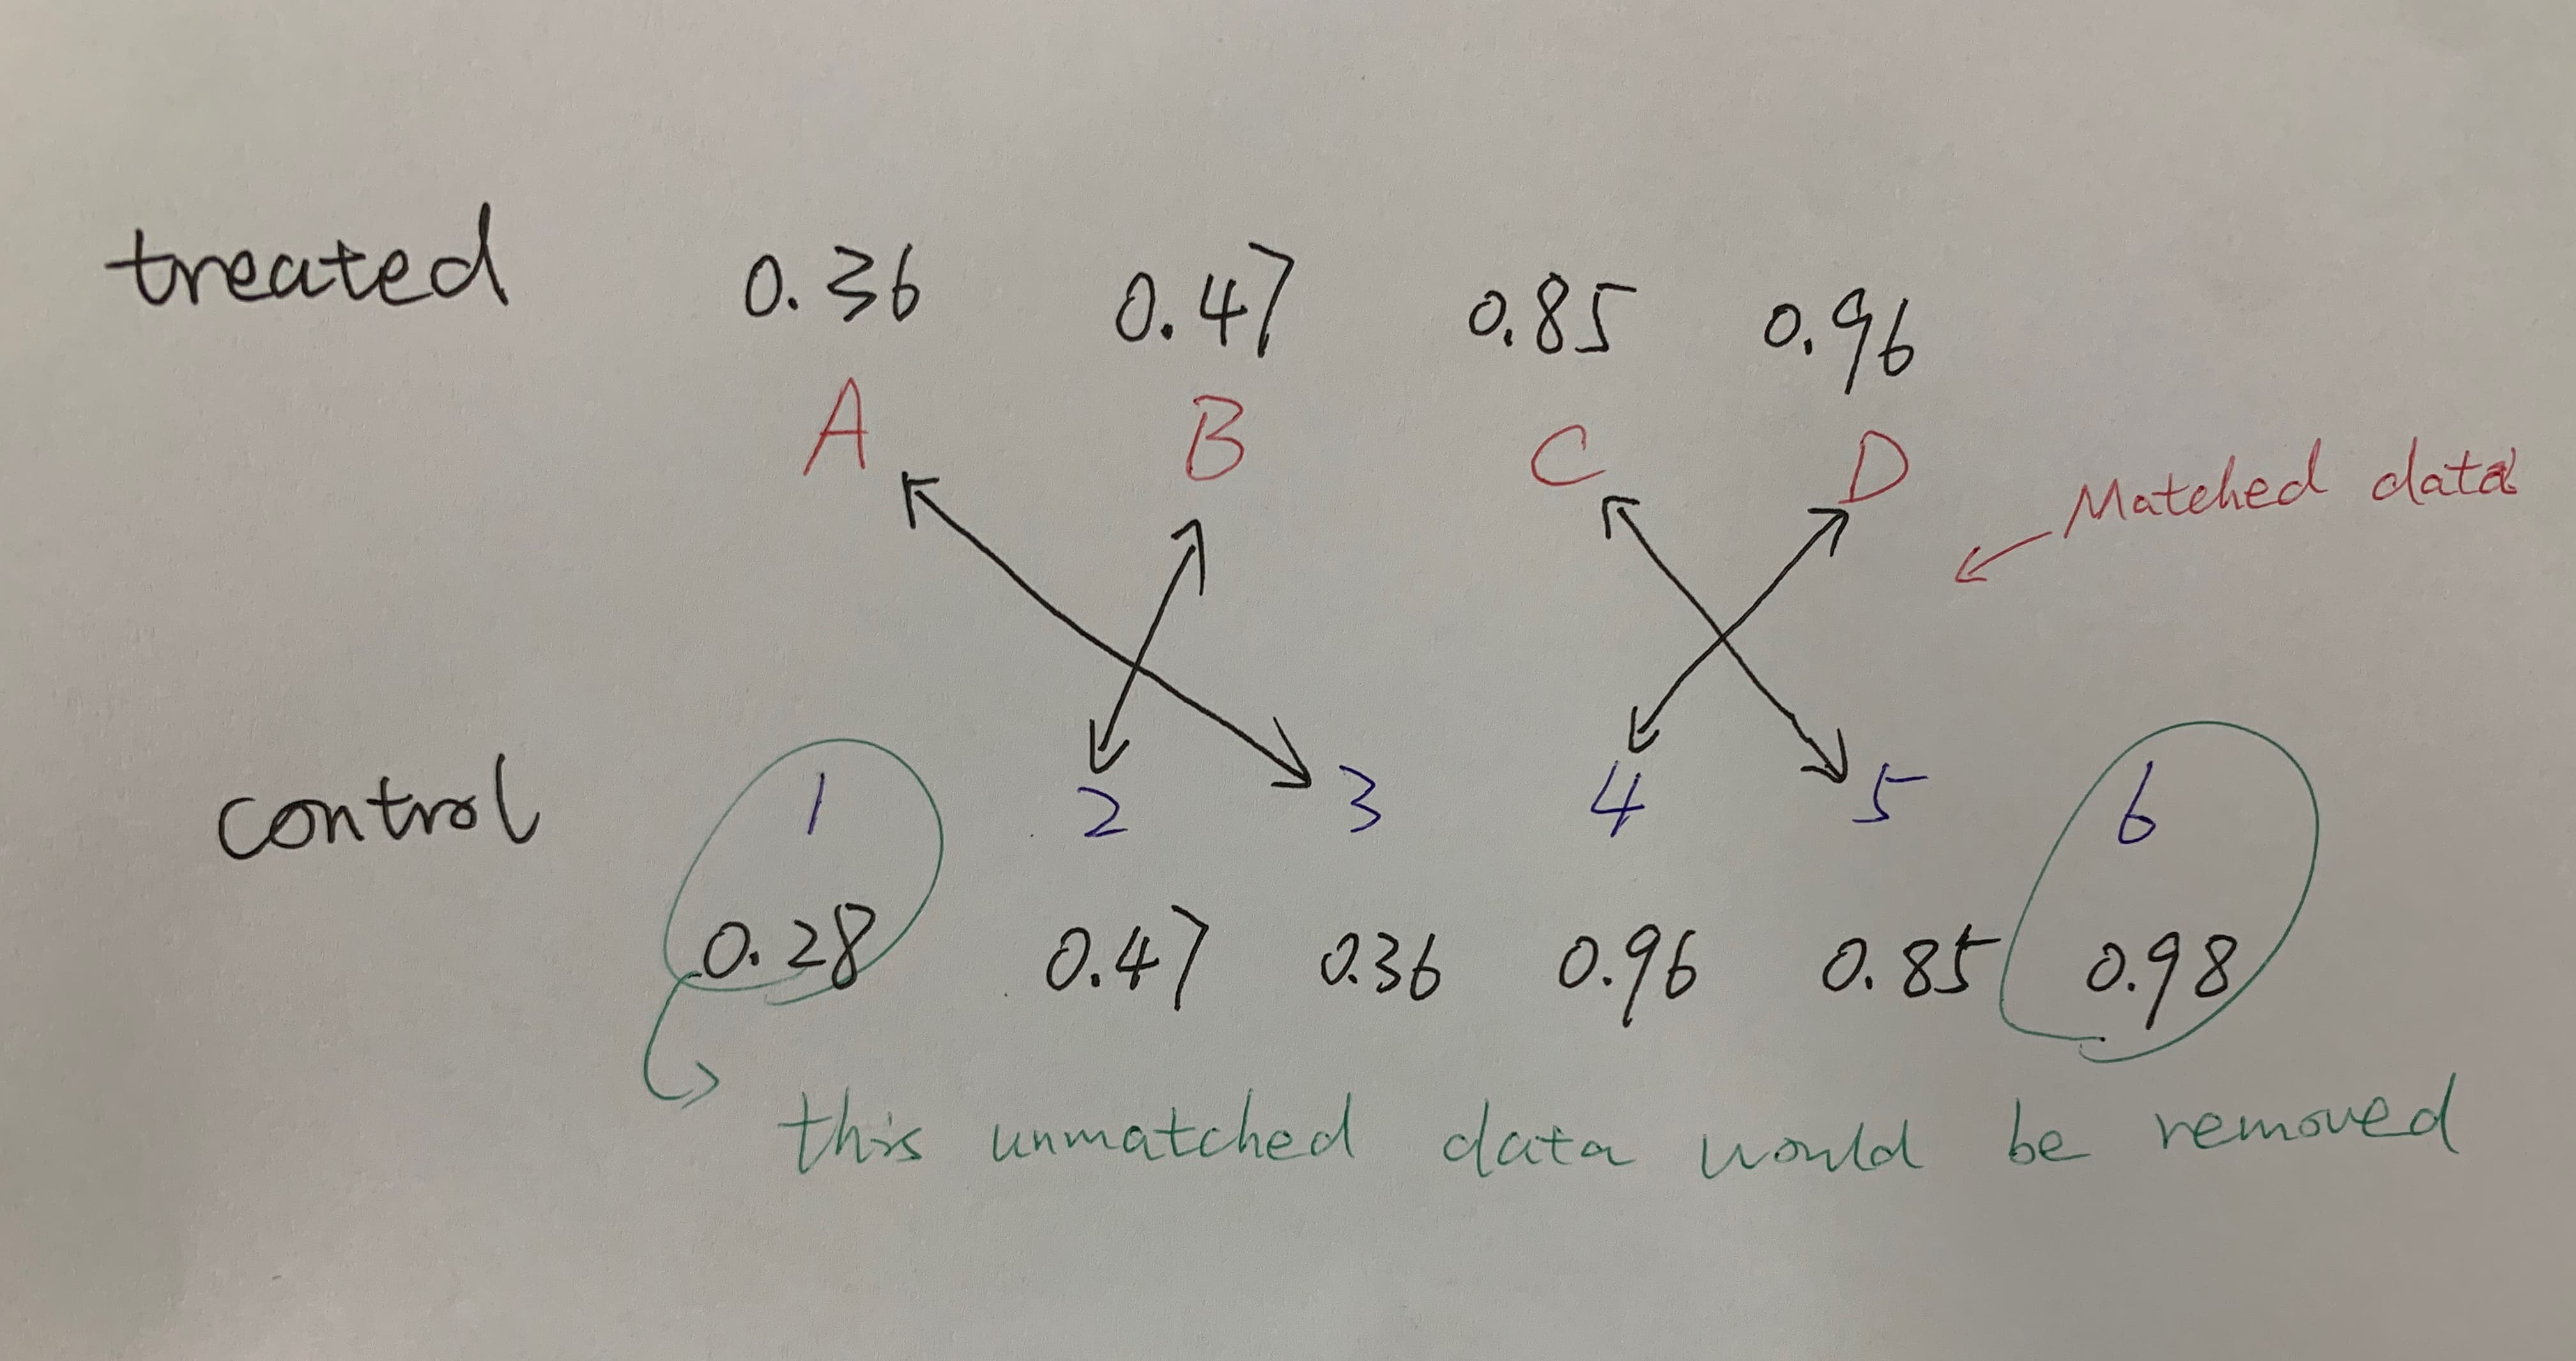

- Steps of PSM

1. Select a suitable algorithm to calculate the propensity score of all samples.
2. Use KNN to find the closest sample. As shown in the figure above, in each sample in the treated group in turn, find the sample that is closest to its score in the control group, that is, calculate min(delta(score)). If there are multiple control samples that meet the condition, proceed All match.
3. We will define a caliper parameter. When the min(delta(score))>caliper calculated in step 2, the matching is unsuccessful and the treated sample would be discarded.

In [ ]:
did_df = pd.read_csv('psm_data_eg.csv')

In [ ]:
did_df.columns

Index(['Unnamed: 0', 'user_id', 'treatment', 'if_on', 'f1', 'f2', 'f3', 'f4',
       'f5', 'f6', 'f7', 'f8', 'f9', 'gender', 'age_range', 'f10',
       'fre_city_level', 'fre_community_type', 'mod_price_range', 'platform',
       'is_install_APP_A', 'is_install_APP_B', 'is_install_APP_C',
       'is_install_APP_D', 'is_install_APP_E', 'is_install_APP_F',
       'is_install_APP_G', 'is_install_APP_H', 'f11', 'f12', 'date'],
      dtype='object')

For example, in this specific AB experiment, what we want to explore is the health status of smokers and non-smokers.
- user_id is the number of each person
- treatment is whether this person is selected into the experimental group, it is 1 in the experimental group, otherwise it is 0.
- if_on is whether this person is smoking. Here is also the y variable we will use as the predict label
- The rest are other features of this person. For example, gender, age, city level, mobile phone price, mobile phone brand and other variables. In order to keep the data confidential, I have done some desensitization of the column names and data.

Generally speaking, we need to predict whether or not to smoke, output the probability of whether each person in the experimental group and the control group smokes, and then match people with the same probability. The characteristics of this group of people are similar.

- Step1 - Find a suitable algorithm

In the first step, we need to find a suitable algorithm. That is, the algorithm that can best predict the probability of smoking. Usually we can try many kinds, such as RandomForest, LogisticRegression, XGboost and LGBM and so on.

Here, the training set we choose is the people in the experimental group. The learned Y label is whether or not to smoke.

In [ ]:
temp = did_df.copy()
temp.drop_duplicates(['user_id','treatment'], inplace = True)
temp.reset_index(drop=True, inplace = True)
temp_treatment=temp[temp.treatment==1]

# only features
temp_X = temp.iloc[:,4:-2]
# get_dummies --- One-hot processing of categorical variables
temp_X = pd.get_dummies(temp_X)
temp_X['treatment'] = temp['treatment'] 
X_train, X_test, y_train, y_test = train_test_split(temp_X[temp_X.treatment==1].iloc[:,:-1], temp_treatment.loc[:,['if_on']], test_size=0.25, random_state=0, stratify=temp_treatment.loc[:,['if_on']])

In [ ]:
# train_rf_model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=6,class_weight='balanced',random_state=0)
rf_model.fit(X_train,y_train)
# train_lr_model
lr_model = LogisticRegression(class_weight='balanced',random_state=0)
lr_model.fit(X_train,y_train)
# train_lgb_model
lgb_model = LGBMClassifier(max_depth=6,class_weight='balanced',random_state=0)
lgb_model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=6, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
# This function for returning different model outcome
def pred_result(model,x,y):
  ypred = model.predict(x)
  pscore = model.predict_proba(x)[:,1]
  accuracy = metrics.accuracy_score(y, ypred)
  fpr, tpr, thresholds = metrics.roc_curve(y, pscore)
  auc_score = metrics.auc(fpr, tpr)
  precision = metrics.precision_score(y, ypred)
  recall = metrics.recall_score(y, ypred)
  f1score = metrics.f1_score(y, ypred)
  return [accuracy,auc_score,precision,recall,f1score]

In [ ]:
result = pd.DataFrame([],index=['accuracy','auc_score','precision','recall','f1score'])   
result['RandomForest'] = pred_result(rf_model,X_test,y_test)
result['LogisticRegression'] = pred_result(lr_model,X_test,y_test)
result['LightGBM'] = pred_result(lgb_model,X_test,y_test)

By trying different algorithms, we found in this example. Relatively speaking, the effect of LGBM will be better. In the next matching, we will choose LGBM as our benchmark model.

In [ ]:
result

,RandomForest,LogisticRegression,LightGBM
accuracy,0.621958,0.389286,0.654735
auc_score,0.655096,0.591485,0.666741
precision,0.331374,0.257299,0.353747
recall,0.585725,0.836703,0.553557
f1score,0.423279,0.393569,0.431651


- Step2 Matching (PSM)

In this step, we will first use the experimental group data to train the model. Then make predictions on all the data. Get the probability of smoking on all samples.

In [ ]:
temp = did_df.copy()
temp.drop_duplicates(['user_id','treatment'], inplace = True)
temp.reset_index(drop=True, inplace = True)
temp_treatment=temp[temp.treatment==1]

# only features
temp_X = temp.iloc[:,4:-2]
# get_dummies --- One-hot processing of categorical variables
temp_X = pd.get_dummies(temp_X)
temp_X['treatment'] = temp['treatment'] 
X_train, X_test, y_train, y_test = train_test_split(temp_X[temp_X.treatment==1].iloc[:,:-1], temp_treatment.loc[:,['if_on']], test_size=0.25, random_state=0, stratify=temp_treatment.loc[:,['if_on']])

In [ ]:
propensity_model = LGBMClassifier(max_depth=6,class_weight='balanced',random_state=0)
propensity_model.fit(X_train,y_train)

pscore = propensity_model.predict_proba(temp_X.iloc[:,:-1])[:,1]
pscore = pd.Series(pscore)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=6, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In the final matching step. We will set a minimum error threshold, which is the caliper here. When the probability error between the experimental group and the control group is less than this value, we will match the two. One thing to note is that the amount of data in the control group must be greater than the amount of data in the experimental group.

In [ ]:
N0, N1 = temp[temp.treatment == 0].index, temp[(temp.treatment == 1)&(temp['if_on'] == 1)].index
g0, g1 = pscore[temp.treatment == 0], pscore[(temp.treatment == 1)&(temp['if_on'] == 1)]

In [ ]:
caliper = 0.05

order = np.random.permutation(N1)
matches = {}

for m in order:
  dif = abs(g1[m] - g0)

  if dif.min() <= caliper:
    matches[m] = [dif.idxmin()]

row = list(set([m for match in matches.values() for m in match])) + [m for m in matches.keys()]
match_id = temp.loc[row, 'user_id']

0         0.251288
3         0.052091
5         0.413566
8         0.367146
9         0.188932
            ...   
302755    0.190344
302757    0.052445
302758    0.138061
302761    0.092256
302763    0.401351
Length: 151564, dtype: float64


Finally, we will get the id of the matching probability between the experimental group and the control group, and then we can truly compare the differences in the health levels of the two groups after the matching. In fact, we find users with similar structures through Matching, which is similar to adding control variables to users and removing the interference caused by other variables to users, so as to get the causal impact of only changing the policy (in this case, whether or not to smoke).

In [ ]:
match_id

262144     151367689
9          699029385
131089      55335374
19         407091005
20         810625062
             ...    
73617      783490945
96754     1021723490
58973      462511860
156608     505218173
263346     782875249
Name: user_id, Length: 62828, dtype: int64

The following is a display of renderings. Before matching, there will be some differences in our samples. After the matching, the other characteristics of the experimental group and the control group will be closer to each other.

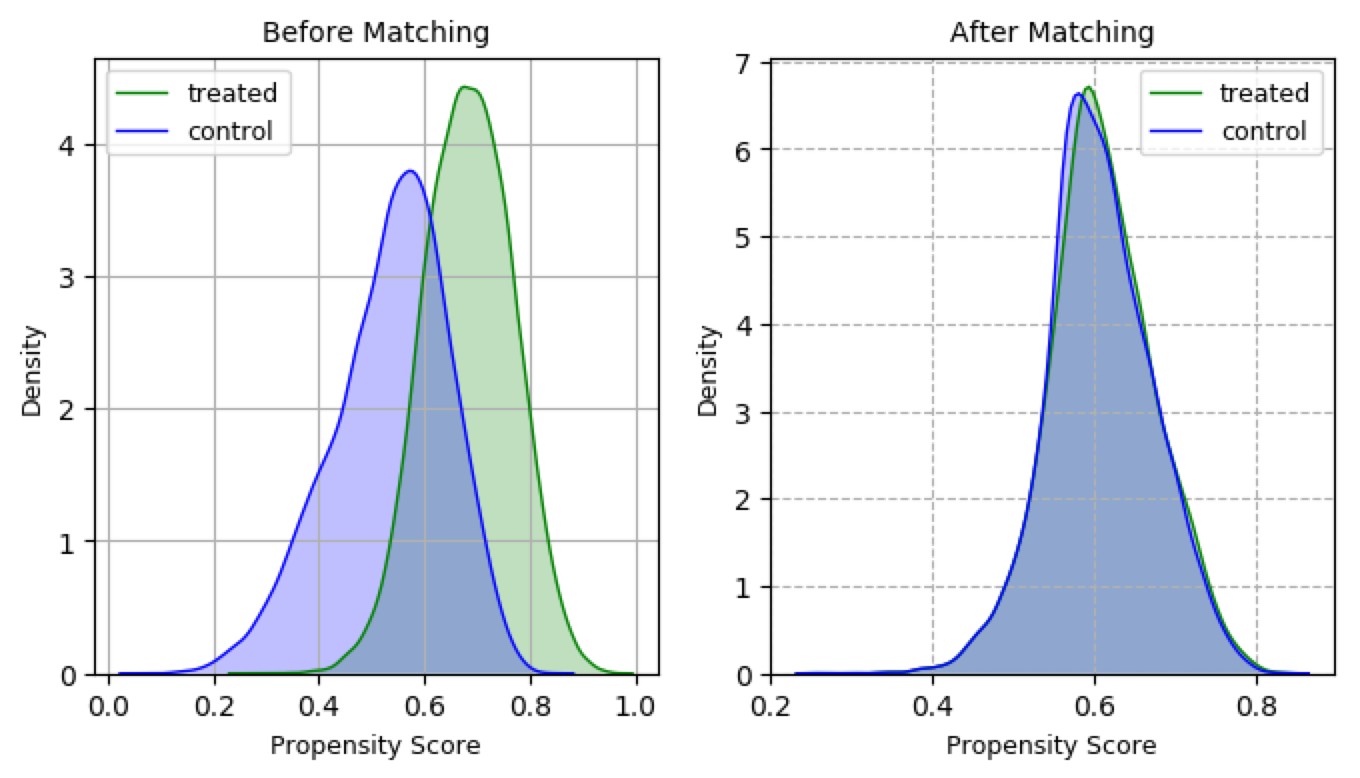

## Summary and references

This tutorial highlighted just a few elements of what is possible with data analyzed for AB test in Python. The AB experiment itself also involves a number of interesting concepts, such as the Difference in Difference (DID) method, Synthetic Control,  Matrix Completion, Ghost Ad. In addition to PSM, Matching also has some other ways to do, such as Coarsened Exact Matching (CEM). Much more detail about the methods are available from the following links.

1. Difference in Difference: 
- https://diff.healthpolicydatascience.org/ 
- https://mixtape.scunning.com/difference-in-differences.html 
2. Coarsened Exact Matching: 
- https://pypi.org/project/cem/
- https://medium.com/@devmotivation/cem-coarsened-exact-matching-explained-7f4d64acc5ef
3. Ghost Ad Methods (From Google): 
- https://www.thinkwithgoogle.com/intl/en-gb/marketing-strategies/monetisation-strategies/a-revolution-in-measuring-ad-effectiveness/
4. Causal Inference 
- https://pypi.org/project/CausalInference/
- https://towardsdatascience.com/implementing-causal-inference-a-key-step-towards-agi-de2cde8ea599
- https://ftp.cs.ucla.edu/pub/stat_ser/r350.pdf
5. Synthetic Control
- https://pypi.org/project/SyntheticControlMethods/
- https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html
6. Matrix Completion
- https://pypi.org/project/matrix-completion/
- https://towardsdatascience.com/recommender-systems-in-python-from-scratch-643c8fc4f704
7. Heterogeneous Treatment Effects (HTE)
- https://egap.org/resource/10-things-to-know-about-heterogeneous-treatment-effects/
- https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-020-01145-1
8. AB testing in Python: 
- https://medium.com/@RenatoFillinich/ab-testing-with-python-e5964dd66143